## Summary

Here we compare the performances of three models using simple linear regression, multi-linear regression (without regularization), and support vector machines. Each of the models is recursively trained using each data point as the test set and the rest of the data points as the training set.

In [25]:
# imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from scipy.stats import sem
import altair as alt
import sys
cur_dir = os.getcwd()
SRC_PATH = cur_dir[
    : cur_dir.index("arm_balance") + len("arm_balance")
]
if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)
    
from src.utils.utils import *

The following code shows using simple linear regression of a single data point:

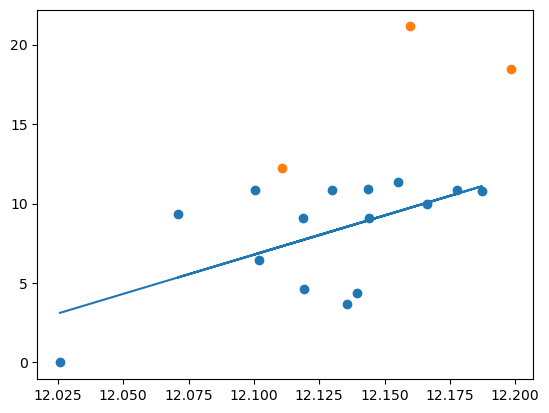

In [52]:
import matplotlib.pyplot as plt
DATA_DIR = '../../data/raw_data/'
files = [DATA_DIR + f for f in files]
train_df, test_df= get_data(files, group_size=1)[:-3] ,get_data(files, group_size=1)[-3:]
lr = LinearRegression()
lr.fit(train_df['1'].to_numpy().reshape(-1, 1), train_df['y'])

lr_df = pd.DataFrame({'train':train_df['1'],
                      'test':test_df['1']})


plt.scatter(train_df['1'], train_df['y'])
def reg(x):
    return lr.coef_*x+lr.intercept_

plt.plot(train_df['1'], reg(train_df['1']))
plt.scatter(test_df['1'],  test_df['y'])

The following code load data by groups of 1000:

In [26]:
DATA_DIR = '../../data/raw_data/'
files = os.listdir(DATA_DIR)
np.random.seed(123)
np.random.shuffle(files)
df = None
group_by_count = 1000 # has to be 10000-divisble 

for data in files:
    content = pd.read_csv(os.path.join(DATA_DIR, data))
    for i in range(len(content)//group_by_count):
        grouped_content = content[i*group_by_count: (i+1)*group_by_count]
        grouped_content = pd.DataFrame(pd.DataFrame(np.average(grouped_content,      axis=0).reshape(1,8), 
                                       columns=content.columns), 
                                       columns=content.columns)
        df = pd.concat([df, grouped_content])
df = df.iloc[: , 1:]
res = pd.DataFrame()

The following code is using linear regression of the second joint:

In [27]:

result = []
target = []
for i in range(len(files)):
    data_count = int(10000/group_by_count)
    test_set = df[i*data_count: (i+1)*data_count]
    test_set_target = np.average(test_set['y'])
    train_set = df.query('y != @test_set_target')
    
    X_train, y_train = train_set.drop(columns=['y']), train_set['y']
    X_test, y_test = test_set.drop(columns=['y']), train_set['y']
    
    lr_pipe = LinearRegression()
    lr_pipe.fit(X_train['2'].to_numpy().reshape(-1, 1),y_train)
    
    error = np.average(lr_pipe.predict(X_test['2'].to_numpy().reshape(-1, 1))) - test_set_target
    
    target.append(test_set_target)
    result.append(np.abs(error))
res['lr'] = result
res['target'] = target

In [28]:
bar_slr = alt.Chart(res).mark_bar(size=5).encode(
     alt.X('target:Q', title ='Actual Mass (g)'),
     alt.Y('lr:Q', title = 'Prediction Error (g)')
).properties(
    title = 'Errors using simple linear regression with groups of 1000 data points'
)
save_chart(bar_slr,'../../report/assets/bar_slr.png')
bar_slr


alt.Chart(...)

In [29]:
result = []
target = []

for i in range(len(files)):
    data_count = int(10000/group_by_count)
    test_set = df[i*data_count: (i+1)*data_count]
    test_set_target = np.average(test_set['y'])
    train_set = df.query('y != @test_set_target')
    
    X_train, y_train = train_set.drop(columns=['y']), train_set['y']
    X_test, y_test = test_set.drop(columns=['y']), train_set['y']
    
    lr_pipe = make_pipeline(LinearRegression())
    lr_pipe.fit(X_train,y_train)
    
    error = np.average(lr_pipe.predict(X_test)) - test_set_target
    
    target.append(test_set_target)
    result.append(np.abs(error))
res['mlr'] = result


In [30]:
bar_mlr = alt.Chart(res).mark_bar(size=5).encode(
     alt.X('target:Q', title ='Actual Mass (g)'),
     alt.Y('mlr:Q', title = 'Prediction Error (g)')
).properties(
    title = 'Errors using multiple linear regression with groups of 1000 data points'
)
save_chart(bar_slr,'../../report/assets/bar_mlr.png')
bar_mlr


alt.Chart(...)

In [42]:
result = []
target = []

for i in range(len(files)):
    data_count = int(10000/group_by_count)
    test_set = df[i*data_count: (i+1)*data_count]
    test_set_target = np.average(test_set['y'])
    train_set = df.query('y != @test_set_target')
    
    X_train, y_train = train_set.drop(columns=['y']), train_set['y']
    X_test, y_test = test_set.drop(columns=['y']), train_set['y']
    svr_pipe = make_pipeline(StandardScaler(), SVR(C = 1000.0, 
                                                   gamma=0.000501187233627273)) #tune_svr(X_train, y_train)
    svr_pipe.fit(X_train, y_train)
    error = np.average(svr_pipe.predict(X_test)) - test_set_target
    
    target.append(test_set_target)
    result.append(np.abs(error))
res['svr'] = result

In [43]:
bar_svr = alt.Chart(res).mark_bar(size=5).encode(
     alt.X('target:Q', title ='Actual Mass (g)'),
     alt.Y('svr:Q', title = 'Prediction Error (g)')
).properties(
    title = 'Errors using support vector machines with groups of 1000 data points'
)
save_chart(bar_slr,'../../report/assets/bar_svr.png')
bar_svr


alt.Chart(...)

In [45]:
box_models = (alt.Chart(res.drop(columns = ['target']).melt())
 .mark_boxplot().encode(
     x=alt.X('value',title='Error (g)'),
     y=alt.Y('variable',title='Model'),
     color='variable'))
save_chart(bar_slr,'../../report/assets/box_models.png')
box_models

alt.Chart(...)